# Adult dataset : TransparentAI full pipeline example

This notebook will explore the full pipeline of model creation using transparentai package.

## Table of content

1. Start the AI
2. Explore data
3. Analyse data bias
4. Prepare data
5. Create model
6. Analyse model performance
7. Analyse model bias
8. Explain local and global predictions
9. Compare with new data (Monitoring)

## Load packages

In [85]:
import numpy as np
import pandas as pd

import transparentai.start as start
from transparentai.datasets import StructuredDataset, load_adult
from transparentai.fairness import DatasetBiasMetric, ModelBiasMetric
from transparentai.models import ClassificationModel
from transparentai.explainer import ModelExplainer
from transparentai.monitoring import Monitoring

# Save all plots generated by the package
from transparentai import plots
plots.save_plot = True
plots.save_dir = 'plots/'
plots.verbose = 1

## 1. Start the AI

In [2]:
start.how_can_i_start()

### How can I start

This function is a helper to show some starting possibilities

├── `transparentai.start.quick_start()` shows you questions about the project. If you complete it, at the end you will have answered questions about if your AI is viable.

├── `transparentai.start.external_link()` shows you external references that can be more accurate to your AI.

In [4]:
answer = start.quick_start()

### Quick start

Those questions were inspired by [ML Canvas](https://www.louisdorard.com/machine-learning-canvas) and [PAIR Guidebook](https://pair.withgoogle.com/).

#### Detail & Goal

`q1` : What is the main goal of this AI ? What do you want to predict ?

Answer here : If an adult has an income greater than 50K


`q2` : Why do you need this AI ?

Answer here : To present transparentai module


`q3` : Who is participating during the AI creation ?

Answer here : Nathan Lauga (data scientist)


`q4` : Can you reach the same goal without AI ? If yes, why AI is better for this problem ?

Answer here : No


`q5` : What decisions will be taken with the output of this AI ?

Answer here : None


`q6` : Who will be affected by this AI ?

Answer here : Nobody


`q7` : How users will respond to this AI : Define some questions that users may asked at the end about the AI prediction.

Answer here : Why this person was predicted with an income greater than 50K ?


#### Model & Metrics

`q8` : What is the type of AI ? (classification, regression , etc.)

Answer here : binary classification


`q9` : Do you need this AI to be train regularly ? How often ?

Answer here : Just once


`q10` : Which evaluation function will you use ? If binary classifier weight on positive or negative ?

Answer here : Accuracy and F1 score.


`q11` : Using this evaluation method, do you think with time, it will affect prediction and be biased ?

Answer here : Maybe


`q12` : Define success metrics : how will you say your AI is succeeding in what it was build for ?

Answer here : If the accuracy is greater than 90%


`q13` : Define negative metrics : how will you say your AI is failing in what it was build for ?

Answer here : If the AI is biased on gender or the accuracy is less than 80%


#### Data

`q14` : What are the data that you’ll need to build this AI ?

Answer here : adult dataset


`q15` : Do you know if your data is reliable ? If no how will you say it can be reliable ?

Answer here : Yes


In [5]:
start.save_answer_to_file(answer=answer,
                          fname='save/answer_start.json',
                          format='json')

## Load data and explore

In [44]:
adult = load_adult()

In [45]:
# Transform age to be a categorical variable for protected attributes
adult['age category'] = np.where(adult['age'] < 26, 'Young',
                                 np.where(adult['age'] < 61, 'Adult','Elder'))

In [46]:
target = 'income'
dataset = StructuredDataset(df=adult, target=target)

In [47]:
dataset.plot_dataset_overview()

#### Dataset shape : (48842, 16)

First 5 rows of the dataset : 

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,age category
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K,Young
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K,Adult
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K,Adult
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K,Adult
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K,Young


In [48]:
dataset.plot_missing_values()

No missing value.

## Take a look at the target

Plot saved at : plots/income_variable_plot.png


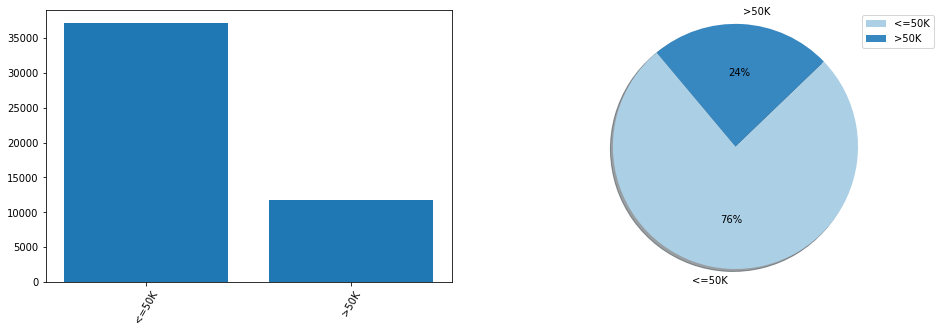

In [9]:
dataset.plot_one_categorical_variable(var='income')

### See correlations

#### Pearson correlation matrix for numerical variables

Plot saved at : plots/pearson_corr.png


#### Cramers V correlation matrix for categorical variables

Plot saved at : plots/cramers_v_corr.png


#### Point Biserial correlation matrix for numerical & categorical variables

Plot saved at : plots/pointbiserialr_corr.png


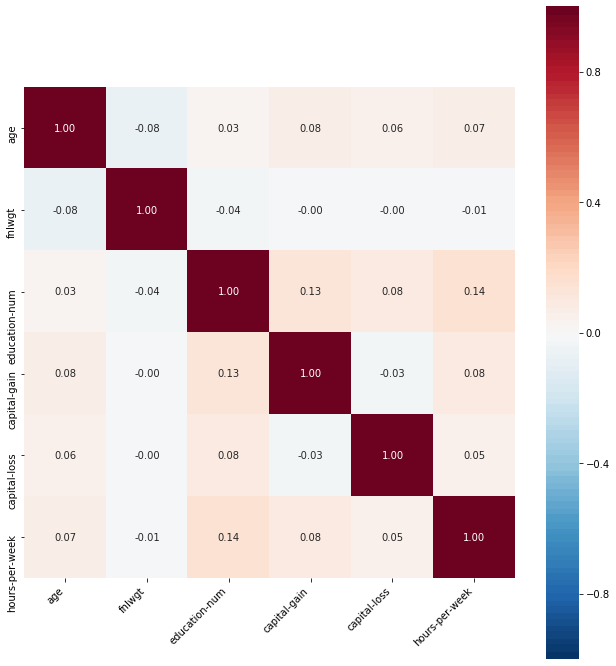

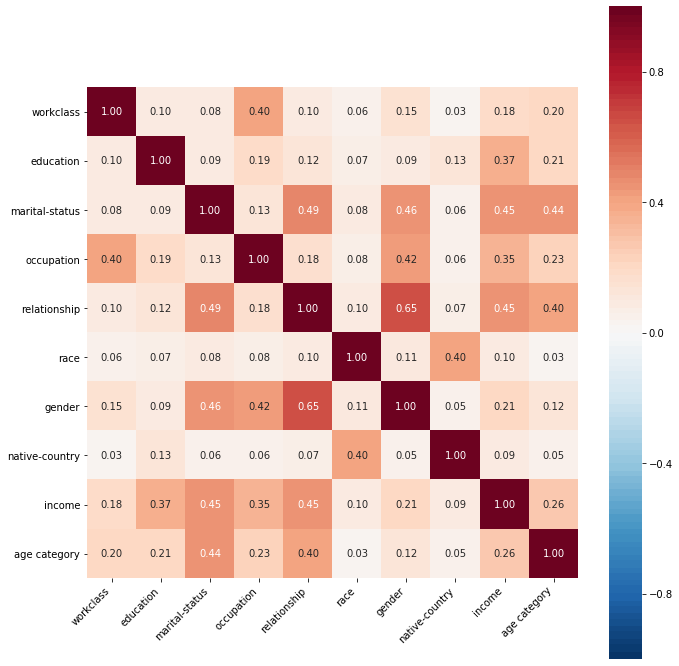

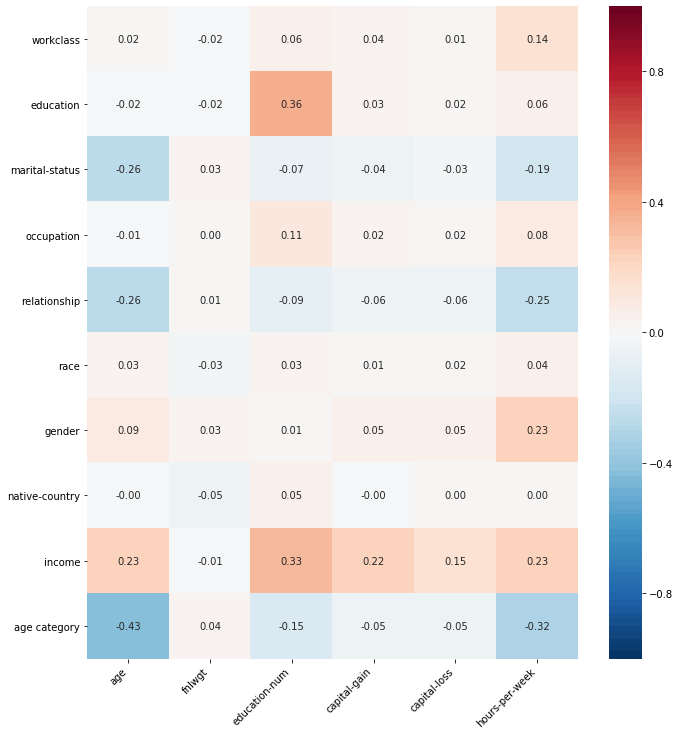

In [10]:
dataset.plot_correlations()

Let's take a look of the correlation between : 
- education-num and hours-per-week
- relationship and age
- income and age

Plot saved at : plots/education-num_hours-per-week_variable_jointplot.png


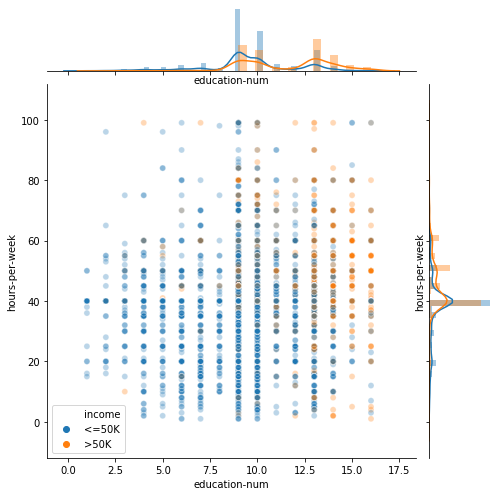

In [11]:
dataset.plot_two_numeric_variables(var1='education-num', var2='hours-per-week', nrows=10000)

Plot saved at : plots/relationship_age_variable_boxplot.png


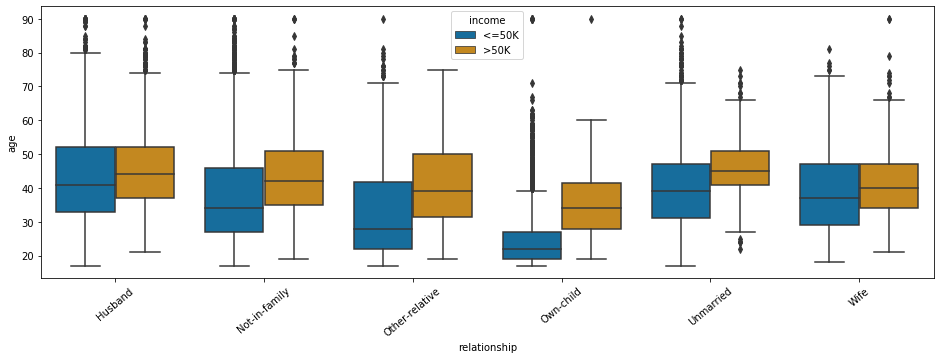

In [9]:
dataset.plot_one_cat_and_num_variables(var1='relationship', var2='age')

Plot saved at : plots/income_age_variable_boxplot.png


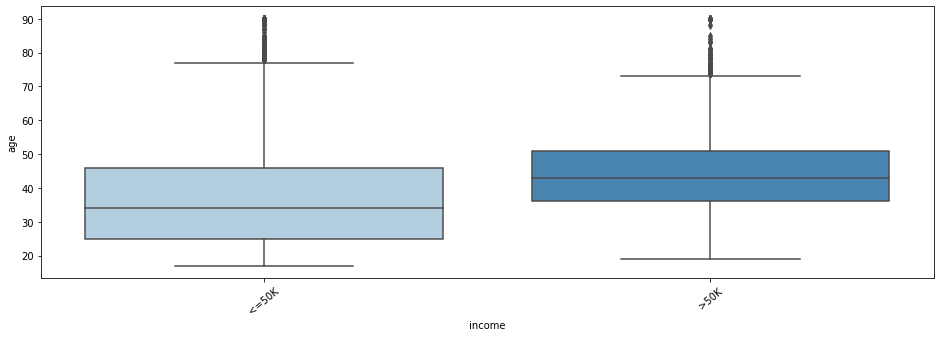

In [10]:
dataset.plot_one_cat_and_num_variables(var1='income', var2='age')

Now that we have some insights we can analyse bias on the dataset

## 3. Analyse data bias

In [5]:
privileged_groups = {
    'age category': ['Adult'],
    'marital-status': ['Married-civ-spouse','Married-AF-spouse'],
    'race': ['White'],
    'gender': ['Male']
}  

In [12]:
dataset_bias = DatasetBiasMetric(dataset, privileged_groups, favorable_label='>50K')

In [13]:
dataset_bias.get_bias_metrics()

,,Disparate impact,Statistical parity difference
attr,index,,
age category,>50K,0.257312,-0.222479
marital-status,>50K,0.143299,-0.382106
race,>50K,0.600592,-0.101445
gender,>50K,0.359655,-0.194516


In [14]:
dataset_bias_orig = dataset_bias.metrics_to_json()

In [16]:
insight = dataset_bias.insight()
insight
for attr, bias_dict in insight.items():
    for target_value, string in bias_dict.items():
        print('---------')
        print(f'{attr} : target_value = {target_value}')
        print(string)

---------
age category : target_value = >50K
For this target value (>50K) regarding the 'age category' attribute 2 for the 2 bias metrics are/is biased so you can considered that the dataset is biased.
---------
marital-status : target_value = >50K
For this target value (>50K) regarding the 'marital-status' attribute 2 for the 2 bias metrics are/is biased so you can considered that the dataset is biased.
---------
race : target_value = >50K
For this target value (>50K) regarding the 'race' attribute 1 for the 2 bias metrics are/is biased so you can considered that the dataset is biased.
---------
gender : target_value = >50K
For this target value (>50K) regarding the 'gender' attribute 1 for the 2 bias metrics are/is biased so you can considered that the dataset is biased.


Plot saved at : plots/dataset_bias_metrics_plot.png


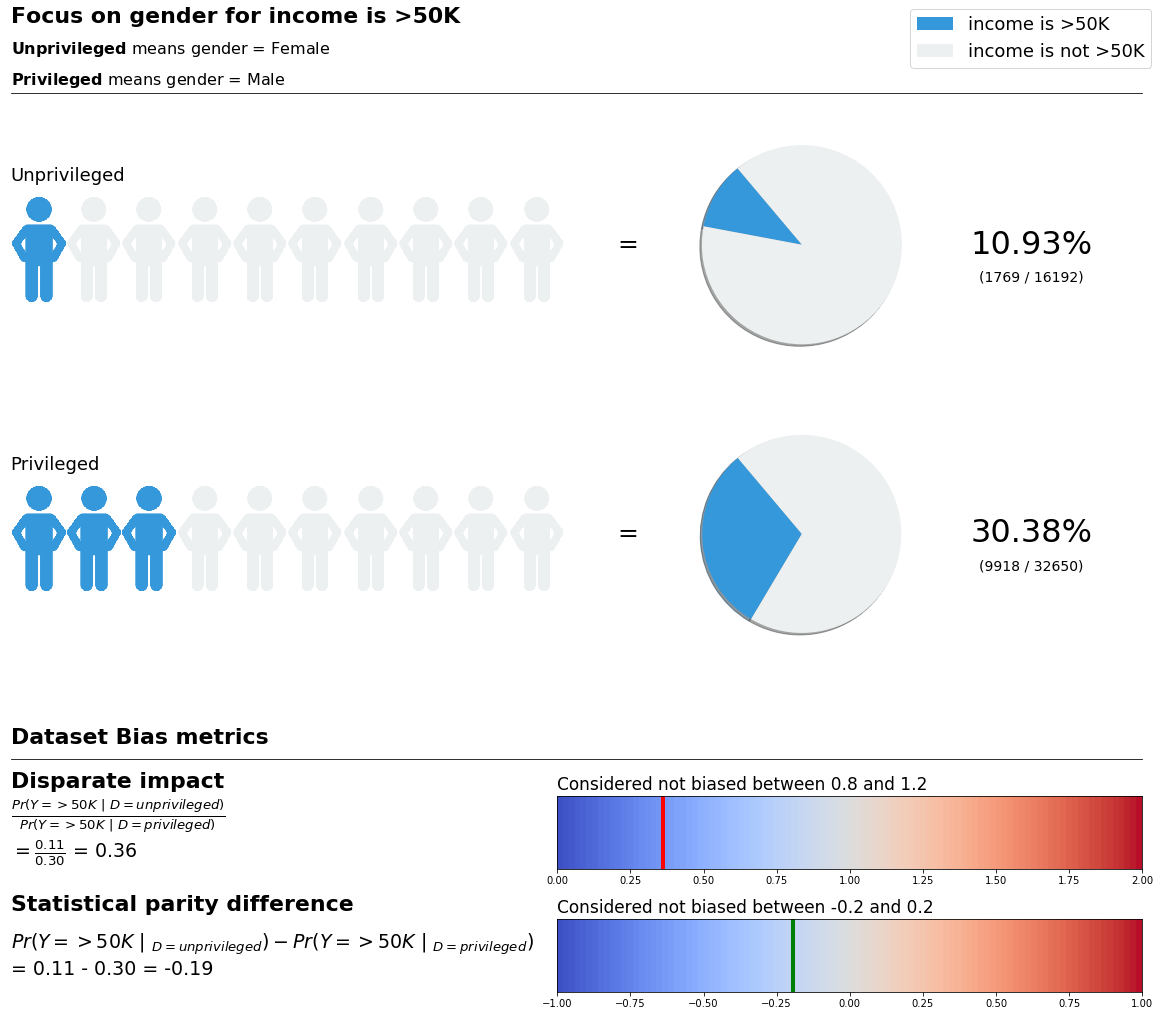

In [19]:
dataset_bias.plot_bias(attr='gender')

## 4. Prepare data

In [49]:
from transparentai.utils import encode_categorical_vars

from sklearn.model_selection import train_test_split

In [50]:
target_value = {'>50K':1, '<=50K':0}
adult[target] = adult[target].replace(target_value)

In [51]:
adult, encoders = encode_categorical_vars(adult)
X, y = adult.drop(columns=target), adult[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## 5. Create model

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

## 6. Analyse model performance

In [34]:
model = ClassificationModel(model=clf)
model.compute_scores(X=X_test, y=y_test)

### Overall model performance

,accuracy,f1,precision,recall,roc_auc
score,0.864313,0.860986,0.859721,0.864313,{0: 0.9104387547348203}


Plot saved at : plots/classification_scores_plot.png


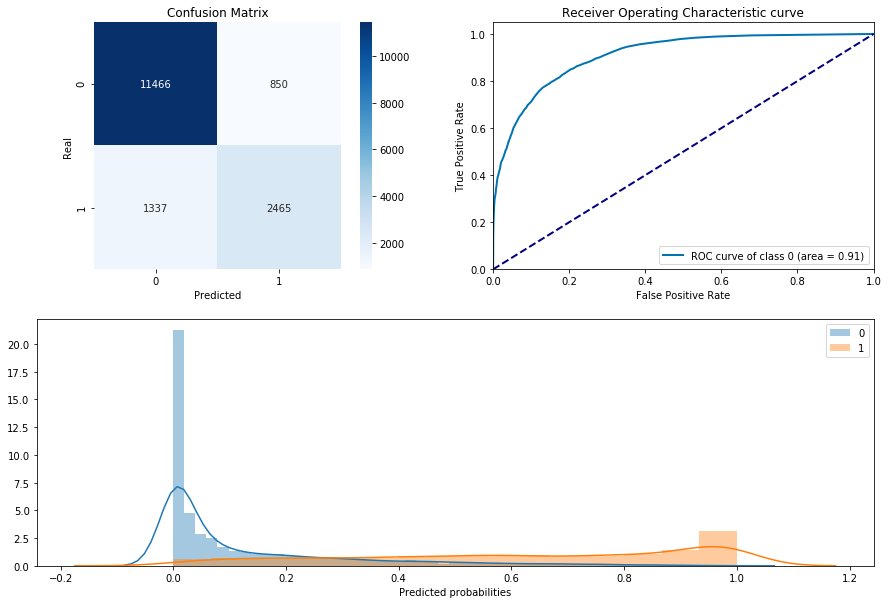

In [35]:
model.plot_scores()

## Proba threshold comparison for accuracy, f1 score, precision & recall

Plot saved at : plots/compare_threshold_predictions_plot.png


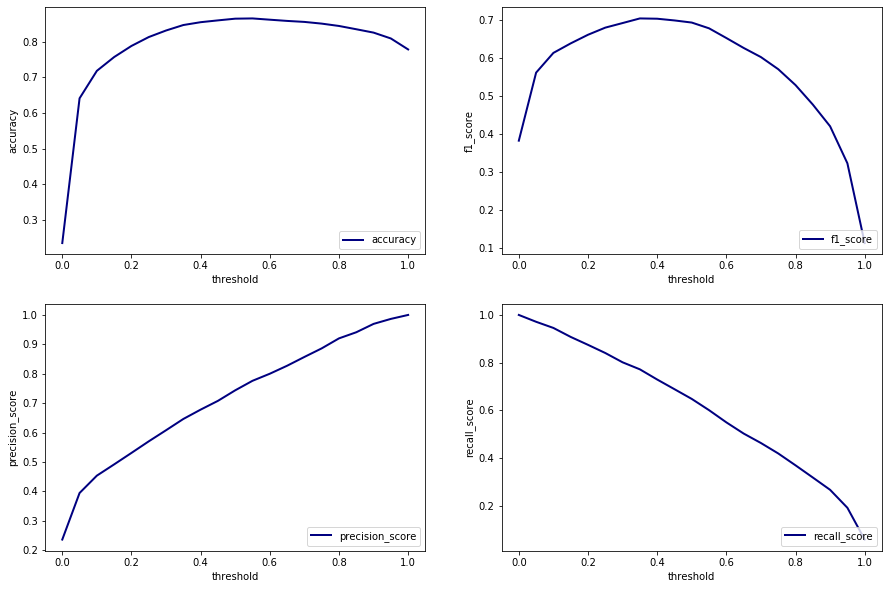

In [37]:
model.plot_threshold()

In [36]:
model_scores_orig = model.scores_to_json()

## 7. Analyse model bias

We need to reverse the encode data to get better insight

In [54]:
X_test_decode = X_test.copy()
y_test_decode = y_test.copy()

In [55]:
preds = pd.Series(clf.predict(X_test)).replace({1:'>50K', 0:'<=50K'})
y_test_decode = y_test_decode.replace({1:'>50K', 0:'<=50K'})

In [56]:
for var in encoders:
    X_test_decode[var] = encoders[var].inverse_transform(X_test_decode[var])

In [57]:
adult_test_decode = pd.concat([X_test_decode, y_test_decode], axis=1)

In [58]:
dataset = StructuredDataset(df=adult_test_decode, target=target)

In [60]:
model_bias = ModelBiasMetric(dataset=dataset, preds=preds,
                             privileged_groups=privileged_groups,
                             favorable_label='>50K')

In [61]:
model_bias.get_bias_metrics()

,,Disparate impact,Statistical parity difference,Equal opportunity difference,Average abs odds difference,Theil index
attr,index,,,,,
age category,>50K,0.239931,-0.192626,-0.086698,0.077004,0.107743
marital-status,>50K,0.079472,-0.373522,-0.275016,0.226959,0.107743
race,>50K,0.516296,-0.104626,-0.043202,0.041003,0.107743
gender,>50K,0.302189,-0.182018,-0.105678,0.087605,0.107743


In [62]:
insight = model_bias.insight()
insight
for attr, bias_dict in insight.items():
    for target_value, string in bias_dict.items():
        print('---------')
        print(f'{attr} : target_value = {target_value}')
        print(string)

---------
age category : target_value = >50K
For this target value (>50K) regarding the 'age category' attribute 1 for the 5 bias metrics are/is biased so you can considered that the dataset is biased.
---------
marital-status : target_value = >50K
For this target value (>50K) regarding the 'marital-status' attribute 4 for the 5 bias metrics are/is biased so you can considered that the dataset is biased.
---------
race : target_value = >50K
For this target value (>50K) regarding the 'race' attribute 1 for the 5 bias metrics are/is biased so you can considered that the dataset is biased.
---------
gender : target_value = >50K
For this target value (>50K) regarding the 'gender' attribute 1 for the 5 bias metrics are/is biased so you can considered that the dataset is biased.


Plot saved at : plots/model_bias_metrics_plot.png


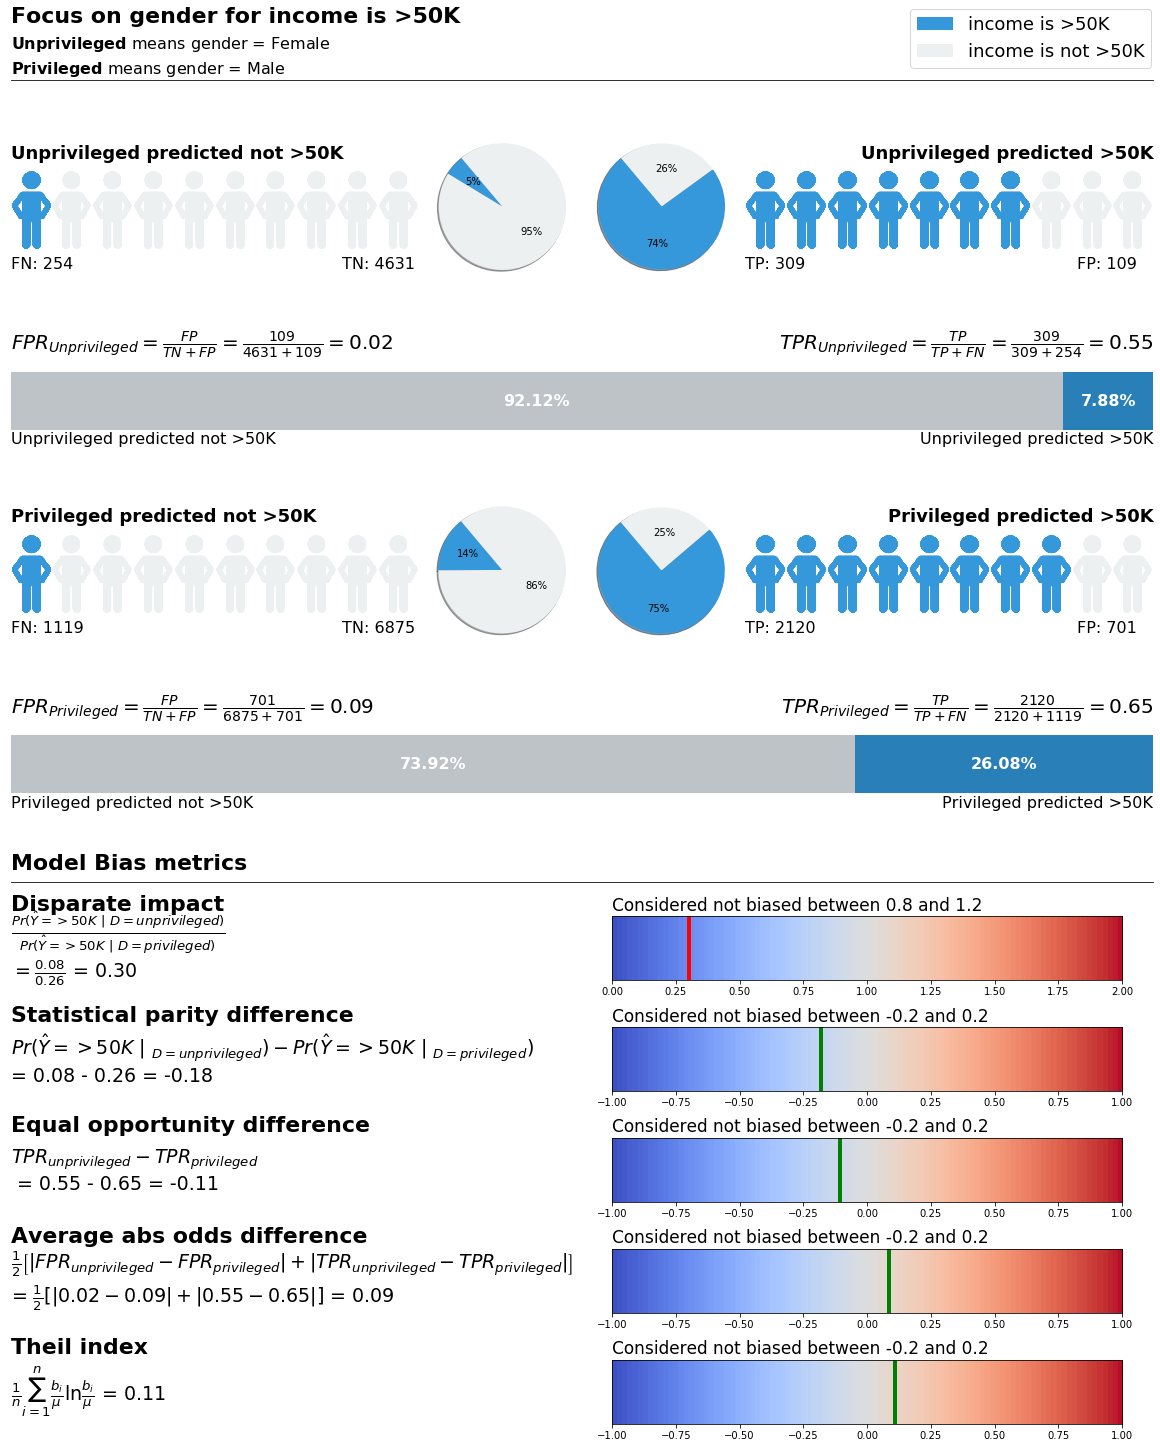

In [63]:
model_bias.plot_bias(attr='gender')

In [65]:
model_bias_orig = model_bias.metrics_to_json()

## 8. Explain local and global predictions

In [68]:
explainer = ModelExplainer(model=clf, X=X_test, model_type='tree')

In [69]:
# I just take 100 rows for the example
explainer.explain_global(X_test.sample(100))

 98%|===================| 197/200 [00:17<00:00]        

{'age': 0.04400247162436626,
 'workclass': 0.012615442187332302,
 'fnlwgt': 0.011500706212146071,
 'education': 0.014303318875909592,
 'education-num': 0.06320364016403923,
 'marital-status': 0.04457869696787154,
 'occupation': 0.025353718692010623,
 'relationship': 0.06538595560703962,
 'race': 0.0030357403950878343,
 'gender': 0.008150837046393543,
 'capital-gain': 0.05191285416804516,
 'capital-loss': 0.004889414454684037,
 'hours-per-week': 0.03416860048567794,
 'native-country': 0.003552990714228435,
 'age category': 0.013148817808960036}

Plot saved at : plots/global_feature_influence_plot.png


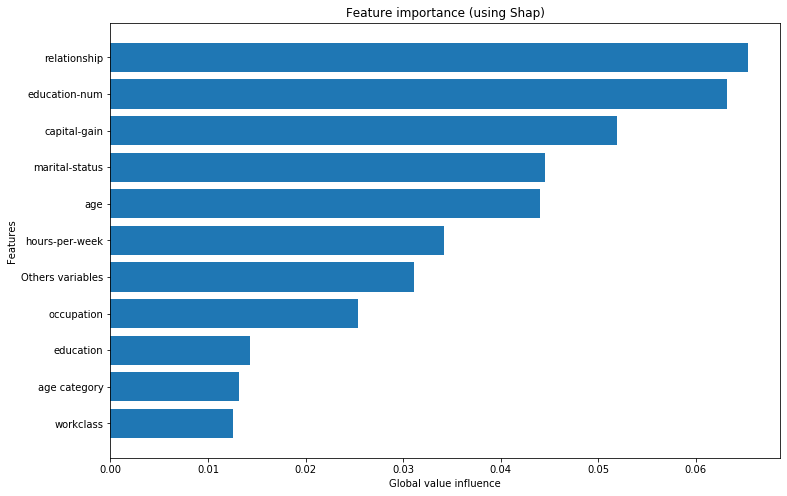

In [70]:
explainer.plot_global_explain(top=10)

For the next part I will create a `feature_classes` dictionary to map encoded values with their original value.

In [71]:
from transparentai.utils import labelencoder_to_dict

In [80]:
feature_classes = dict()
for feat, encoder in encoders.items():
    feature_classes[feat] = labelencoder_to_dict(encoder)

# What it looks like 
feature_classes['gender']

{0: 'Female', 1: 'Male'}

In [84]:
one_row = X.iloc[42]
one_row.to_frame().T

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,age category
42,36,4,465326,11,9,2,5,0,4,1,0,0,40,39,0


In [81]:
explainer.explain_local(one_row, feature_classes=feature_names)

{'age=36': 0.001512160581860371,
 'workclass=Private': -0.001553052083354487,
 'fnlwgt=465326': 0.014316324086275927,
 'education=HS-grad': -0.008492161121589561,
 'education-num=9': -0.06452835138642059,
 'marital-status=Married-civ-spouse': 0.028260101147975548,
 'occupation=Farming-fishing': -0.09721002961961403,
 'relationship=Husband': 0.04156683952625826,
 'race=White': -2.3502936087425042e-05,
 'gender=Male': 0.002139375823244336,
 'capital-gain=0': -0.044484324557015495,
 'capital-loss=0': -0.007543452374593471,
 'hours-per-week=40': -0.014963517277665232,
 'native-country=United-States': -0.0014164286240020375,
 'age category=Adult': 0.004620017927818481}

Plot saved at : plots/local_feature_influence_plot.png


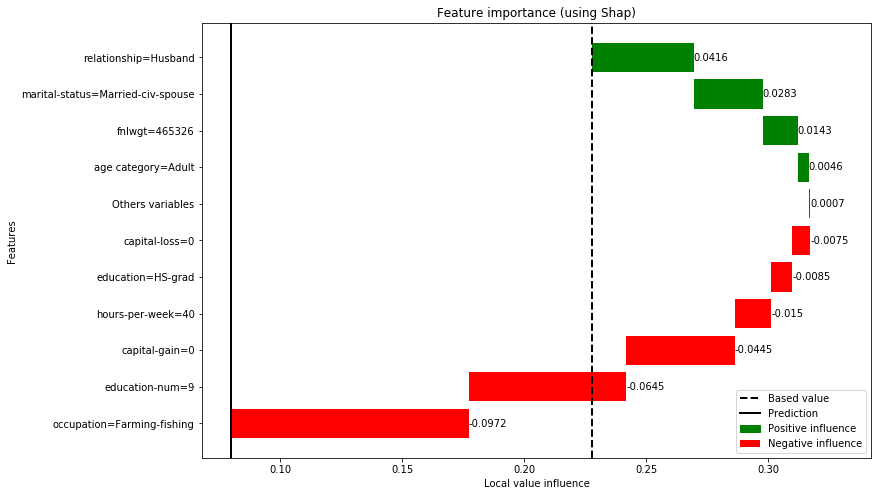

In [82]:
explainer.plot_local_explain(one_row, top=10, 
                             feature_classes=feature_names)

## 9. Compare with new data (Monitoring)

For this section we have to imagine that a sample of my test data is considered as a new set of data.

In [92]:
new_X = X_test.sample(100)
new_y = y_test.loc[new_X.index].replace({0:'<=50K',1:'>50K'})
new_y_preds = pd.Series(clf.predict(new_X)).replace({0:'<=50K',1:'>50K'})
new_X = X_test_decode.loc[new_X.index]

In [93]:
orig_metrics = {
    'performance':model_scores_orig,
    'bias_dataset':dataset_bias_orig,
    'bias_model':model_bias_orig
}

In [94]:
alert_threshold = {
    'accuracy':0.8,
    'f1':0.7
}

In [97]:
monitoring = Monitoring(X=new_X, y_preds=new_y_preds, 
                        y_real=new_y,
                        privileged_groups=privileged_groups,
                        orig_metrics=orig_metrics,
                        alert_threshold=alert_threshold,
                        model_type='classification')

In original performance dict 'roc_auc' key is in but not in the new one.


Plot saved at : plots/monitoring_bar_performance_plot


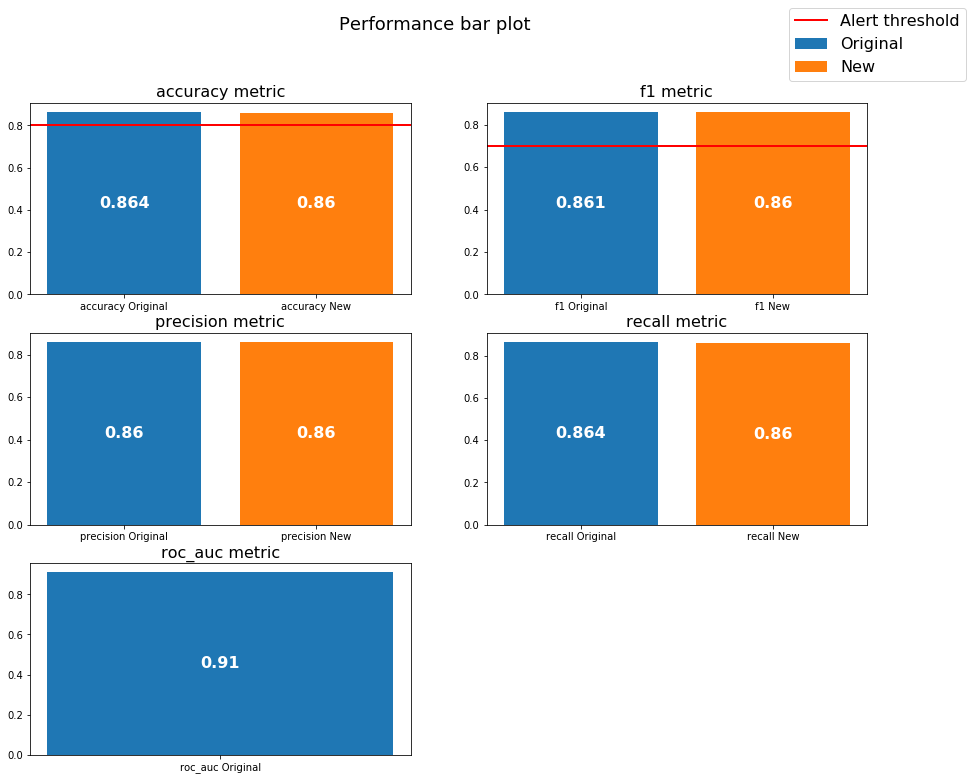

In [98]:
monitoring.plot_perfomance()

Plot saved at : plots/monitoring_gender_>50K_gauge_bias_plot.png


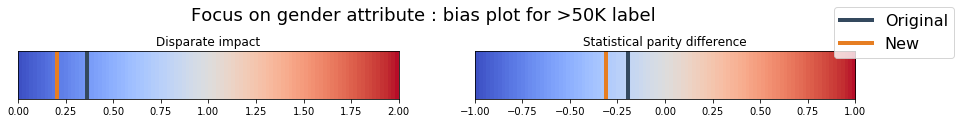

In [99]:
monitoring.plot_dataset_bias(attr='gender',target_value='>50K')

Plot saved at : plots/monitoring_gender_>50K_gauge_bias_plot.png


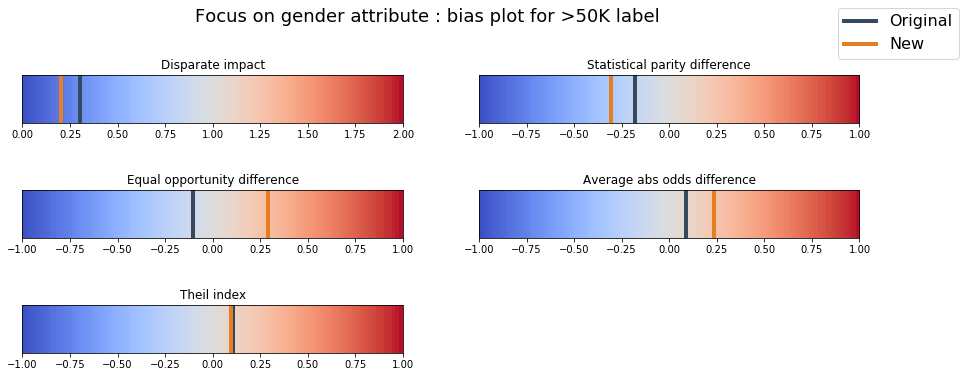

In [100]:
monitoring.plot_model_bias(attr='gender',target_value='>50K')

So there you have some code example to use `transparentai` package. I hope it helps you to have a better understanding of this tool!

Thanks for reading.

## The end.